# Handling unbalanced dataset
Two methods that are worth trying :
1. Generating new data using machine translations
2. Adjusting the threshold

I will focus on generating new data using machine translations here.

# Prepare the spam emails to be fed into machine translator


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf # conda install -c conda-forge tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
url = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/SMSSpamCollection" #Use the RAW one
messages = pd.read_csv(url, sep ='\t', names=["label", "message"])

In [12]:
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [13]:
print(len(messages[messages.label=='spam']))
print(len(messages[messages.label=='ham']))
messages.describe()

747
4825


,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# Removing duplicates

In [14]:
messages = messages.drop_duplicates()
print(len(messages[messages.label=='spam']), 747)
print(len(messages[messages.label=='ham']), 4825)

653 747
4516 4825


In [16]:
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']
spam_msg = spam_msg.drop(labels='label', axis=1)
print(len(ham_msg), len(spam_msg))

4516 653


In [9]:
#spam_msg.to_csv('spam.csv', index=False) #Then convert to .xlsx to use on Google Translate

# Using a machine translator
I simply use https://translate.google.be

I used 6 languages : French, Dutch, German, Spanish, Finnish and Swedish.
Then I copy-pasted the text in the .xlsx file into a blank file.
With the addition of the normal dataset, we have 7*653=4571 spam messages and 4516 ham messages.

In [17]:
url2 = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/BacktranslatedSpam"
#Tokenizer can handle the fact that some lines start with whitespace
new_spam = pd.read_csv(url2, sep ='\t', names=["message"]) # No label like the usual file here

In [18]:
spam_labels = ["spam" for i in range(len(new_spam))]
new_spam.insert(0, "label", spam_labels, allow_duplicates=True) # Making the datasets have the same format
new_spam

,label,message
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,spam,FreeMsg Hey there darling it's been 3 week's n...
2,spam,WINNER!! As a valued network customer you have...
3,spam,Had your mobile 11 months or more? U R entitle...
4,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
4566,spam,Do you want explicit SEX in 30 seconds? Call ...
4567,spam,ASKED 3MOBILE ABOUT 0870 CHATLINES INCLUDED IN...
4568,spam,Did your mobile contract last 11 months? Late...
4569,spam,REMINDER FROM O2: To get £ 2.50 free call cre...


In [19]:
print(len(ham_msg), len(new_spam)) #new_spam also contains original copy of data

4516 4571


In [20]:
new_spam_df = new_spam.sample(n = len(ham_msg), random_state = 754)
print(ham_msg.shape, new_spam_df.shape)

(4516, 2) (4516, 2)


In [21]:
msg_df = pd.concat([ham_msg, new_spam_df])
msg_df.reset_index(drop=True)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,ham,Even my brother is not like to speak with me. ...
...,...,...
9027,spam,"<Redirected from 21870000>Hello, this is your..."
9028,spam,don't know you and you don't know me. Send CH...
9029,spam,"You can stop more club tones by answering ""ST..."
9030,spam,"Latest news! Police station toilet stolen, po..."


In [22]:
msg_labels = (msg_df['label'].map({'ham': 0, 'spam': 1})).values

In [23]:
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'],
                                                                  msg_labels,
                                                                  test_size=0.2,
                                                                  random_state=705)

In [24]:
#Tokenizer : turn words into integers
oov_tok = "<OOV>" # What to replace words that are not in the vocabulary with
vocab_size = 500 # Maximum number of words for tokenizer

tokenizer = Tokenizer(num_words = vocab_size,
                      char_level=False, # Work words by word
                      oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

# Analyzing how many words we drop based on vocabulary size

In [25]:
total = 0
n_words = 0
for word, num in tokenizer.word_counts.items():
    total += num
    n_words += 1

print("We have {t} words in total".format(t=total))
print("We have {n} unique words in total".format(n=n_words))

We have 144030 words in total
We have 8862 unique words in total


In [26]:
count_list = []
for word, num in tokenizer.word_counts.items():
    count_list.append(num)
count_list.sort(reverse=True)

for i in [500, 1000, 1500]:
    n_words_removed = 0
    for j in range(i, n_words):
        n_words_removed += count_list[j]
    print("We remove {n} words with a vocabulary size of {v}, \
          proportion equal to {p}".format(n=n_words_removed, v=i, p=n_words_removed/total))

We remove 42181 words with a vocabulary size of 500,           proportion equal to 0.29286259806984655
We remove 27966 words with a vocabulary size of 1000,           proportion equal to 0.1941678816913143
We remove 20812 words with a vocabulary size of 1500,           proportion equal to 0.14449767409567452


In [29]:
training_sequences = tokenizer.texts_to_sequences(train_msg)
testing_sequences = tokenizer.texts_to_sequences(test_msg)

list_length = np.empty(1)
for sentence in (training_sequences + testing_sequences):
    list_length = np.append(list_length, len(sentence))

print(len(training_sequences + testing_sequences))
print(np.mean(list_length), np.std(list_length))
print(np.quantile(list_length, 0.75))
print(np.quantile(list_length, 0.90))
print(np.quantile(list_length, 0.95))
print(np.quantile(list_length, 0.99))
print(np.quantile(list_length, 0.9925))
print(np.quantile(list_length, 0.995 )) #So with length of 50 words, we're good for the vast majority of them

9032
20.011163511568693 10.792139427731561
28.0
32.0
33.0
41.0
47.0
55.0


In [24]:
# Sequencing and padding on training and testing 
max_len = 50 # Max number of tokens, used with truncating and padding
trunc_type = "post" # Truncates sequences of tokens that are longer than max_len, post=right side
padding_type = "post" # Pads AFTER (with post) if sequence is shorter than max_len

training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                               padding = padding_type, truncating = trunc_type)

In [25]:
X_train = torch.from_numpy(training_padded).float()
X_test = torch.from_numpy(testing_padded).float()
Y_train = torch.from_numpy(train_labels).float()
Y_test = torch.from_numpy(test_labels).float()

In [26]:
iters = 128

net = nn.Sequential(
    nn.Linear(max_len, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(),
)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=.01)

loss_history = [] #Per epoch
accuracy_history = []
accuracy_test_history = []
sensitivity_history = [] # True positive rate
specificity_history = [] # True negative rate

for i in range(iters):
    proba_pred = net(X_train)  # forward pass
    proba_pred = proba_pred.squeeze(-1)  # transform the 1-element vectors into scalars

    optimizer.zero_grad() # reset the gradients to 0
    loss = criterion(proba_pred, Y_train)
    loss_history.append(loss.item()) # .item() to turn it into a python number
    loss.backward()  # obtain the gradients with respect to the loss
    optimizer.step()  # perform one step of gradient descent

    with torch.no_grad():
        Y_pred = proba_pred > 0.5  # Binary label
        accuracy = (Y_train == Y_pred).float().mean()
        accuracy_history.append(accuracy.item())
            
    with torch.no_grad():
        proba_pred_test = net(X_test)
        proba_pred_test = proba_pred_test.squeeze(-1)
        Y_pred_test = proba_pred_test > 0.5
        
        tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_test).ravel()
        accuracy_test_history.append((tn+tp)/(tn+fp+fn+tp))
        sensitivity_history.append(tp/(tp+fn))
        specificity_history.append(tn/(tn+fp))
    
    print("Iteration {iter} done".format(iter=i+1))
    print("Training accuracy is equal to {trainAcc}".format(trainAcc=accuracy_history[-1]))
    print("Test accuracy is equal to {t}".format(t=accuracy_test_history[-1]))
    print("Sensitivity is equal to {t}".format(t=sensitivity_history[-1]))
    print("Specificity is equal to {t}".format(t=specificity_history[-1]))

Iteration 1 done
Training accuracy is equal to 0.5505882501602173
Test accuracy is equal to 0.5451023796347537
Sensitivity is equal to 0.9850905218317358
Specificity is equal to 0.06912442396313365
Iteration 2 done
Training accuracy is equal to 0.5209688544273376
Test accuracy is equal to 0.5356945213060321
Sensitivity is equal to 0.9893503727369543
Specificity is equal to 0.044930875576036866
Iteration 3 done
Training accuracy is equal to 0.5136331915855408
Test accuracy is equal to 0.5921416712783619
Sensitivity is equal to 0.972310969116081
Specificity is equal to 0.18087557603686635
Iteration 4 done
Training accuracy is equal to 0.567750871181488
Test accuracy is equal to 0.6873270614277809
Sensitivity is equal to 0.8977635782747604
Specificity is equal to 0.4596774193548387
Iteration 5 done
Training accuracy is equal to 0.6782007217407227
Test accuracy is equal to 0.7149972329828445
Sensitivity is equal to 0.731629392971246
Specificity is equal to 0.6970046082949308
Iteration 6 do

Iteration 53 done
Training accuracy is equal to 0.8034601807594299
Test accuracy is equal to 0.7963475373547316
Sensitivity is equal to 0.8551650692225772
Specificity is equal to 0.7327188940092166
Iteration 54 done
Training accuracy is equal to 0.804152250289917
Test accuracy is equal to 0.7969009407858328
Sensitivity is equal to 0.8541001064962727
Specificity is equal to 0.7350230414746544
Iteration 55 done
Training accuracy is equal to 0.8042906522750854
Test accuracy is equal to 0.7974543442169342
Sensitivity is equal to 0.8551650692225772
Specificity is equal to 0.7350230414746544
Iteration 56 done
Training accuracy is equal to 0.805121123790741
Test accuracy is equal to 0.7974543442169342
Sensitivity is equal to 0.8541001064962727
Specificity is equal to 0.7361751152073732
Iteration 57 done
Training accuracy is equal to 0.8053979277610779
Test accuracy is equal to 0.7969009407858328
Sensitivity is equal to 0.8541001064962727
Specificity is equal to 0.7350230414746544
Iteration 58

Iteration 107 done
Training accuracy is equal to 0.8210380673408508
Test accuracy is equal to 0.8040951853901495
Sensitivity is equal to 0.8434504792332268
Specificity is equal to 0.761520737327189
Iteration 108 done
Training accuracy is equal to 0.8214532732963562
Test accuracy is equal to 0.8035417819590481
Sensitivity is equal to 0.8402555910543131
Specificity is equal to 0.7638248847926268
Iteration 109 done
Training accuracy is equal to 0.8215916752815247
Test accuracy is equal to 0.805201992252352
Sensitivity is equal to 0.8402555910543131
Specificity is equal to 0.7672811059907834
Iteration 110 done
Training accuracy is equal to 0.8222837448120117
Test accuracy is equal to 0.8074156059767571
Sensitivity is equal to 0.8434504792332268
Specificity is equal to 0.7684331797235023
Iteration 111 done
Training accuracy is equal to 0.8233910202980042
Test accuracy is equal to 0.8057553956834532
Sensitivity is equal to 0.8434504792332268
Specificity is equal to 0.7649769585253456
Iterati

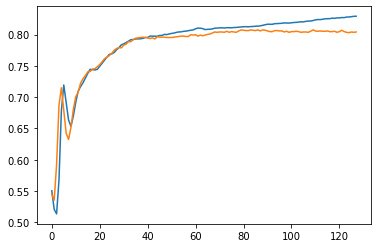

In [27]:
plt.plot(accuracy_history)
plt.plot(accuracy_test_history)

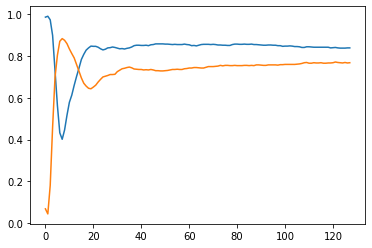

In [28]:
plt.plot(sensitivity_history)
plt.plot(specificity_history)

In [29]:
print(accuracy_test_history[-1], sensitivity_history[-1], specificity_history[-1])

0.8040951853901495 0.838125665601704 0.7672811059907834
